# Empirical Gramians and DSS

## EMGR Framework

These codes are from `https://github.com/gramian/emgr`.

**Note**

Within `ssp2()`, the line: `y[:, k] = g(xk1, uCurr, p, tCurr).flatten(0)` was modified for the original code to `y[:, k] = g(xk1, uCurr, p, tCurr).flatten()`. I believe this issues stems from the version of `numpy` the code was developed with versus what I am using. This should not cause an issue.

This line in `emgr` was also modified ot include a flatten: `vInit = vSteadyState + (vUnit[:nStates].flatten())`

Addtionally, codes related to emgrs besides observability were removed.

### def emgr

In [1]:
"""
emgr - EMpirical GRamian Framework
==================================

  project: emgr ( https://gramian.de )
  version: 5.99.py (2022-04-13)
  authors: Christian Himpe (0000-0003-2194-6754)
  license: BSD-2-Clause License (opensource.org/licenses/BSD-2-Clause)
  summary: Empirical system Gramians for (nonlinear) input-output systems.

DESCRIPTION:
------------

  Empirical gramian matrix and empirical covariance matrix computation
  for model reduction, decentralized control, nonlinearity quantification,
  sensitivity analysis, parameter identification, uncertainty quantification &
  combined state and parameter reduction of large-scale input-output systems.
  Data-driven analysis of input-output coherence and system-gramian-based
  nonlinear model order reduction. Compatible with PYTHON3.

BRIEF:
------

  Unsupervised learning of I/O system properties for data-driven control.

ALGORITHM:
----------

  C. Himpe (2018). emgr - The Empirical Gramian Framework. Algorithms 11(7):91
  doi:10.3390/a11070091

USAGE:
------

  W = emgr(f,g,s,t,w,[pr],[nf],[ut],[us],[xs],[um],[xm],[dp])

MANDATORY ARGUMENTS:
--------------------

   f {function} vector field handle: x' = f(x,u,p,t)
   g {function} output function handle: y = g(x,u,p,t)
   s {tuple} system dimensions: [inputs, states, outputs]
   t {tuple} time discretization: [time-step, time-horizon]
   w {string} single character encoding gramian type:
    * "c" empirical controllability gramian (Wc)
    * "o" empirical observability gramian (Wo)
    * "x" empirical cross gramian (Wx aka Wco)
    * "y" empirical linear cross gramian (Wy)
    * "s" empirical sensitivity gramian (Ws)
    * "i" empirical identifiability gramian (Wi)
    * "j" empirical joint gramian (Wj)

OPTIONAL ARGUMENTS:
-------------------

  pr {matrix|0} parameter vector(s), each column is one parameter sample
  nf {tuple|0} option flags, thirteen component vector, default all zero:
    * centering: none(0), steady(1), last(2), mean(3), rms(4), midrange(5)
    * input scales: single(0), linear(1), geometric(2), log(3), sparse(4)
    * state scales: single(0), linear(1), geometric(2), log(3), sparse(4)
    * input rotations: unit(0), single(1)
    * state rotations: unit(0), single(1)
    * normalization (only: Wc, Wo, Wx, Wy): none(0), steady(1), Jacobi(2)
    * state gramian variant:
      * controllability gramian type (only: Wc, Ws): regular(0), output(1)
      * observability gramian type (only: Wo, Wi): regular(0), averaged(1)
      * cross gramian type (only: Wx, Wy, Wj): regular(0), non-symmetric(1)
    * extra input (only: Wo, Wx, Ws, Wi, Wj): no(0), yes(1)
    * parameter centering (only: Ws, Wi, Wj): none(0), lin(1), log(2), nom(3)
    * parameter gramian variant:
      * averaging type (only: Ws): input-state(0), input-output(1)
      * Schur-complement (only: Wi, Wj): approx(0), coarse(1)
    * cross gramian partition size (only: Wx, Wj): full(0), partitioned(<N)
    * cross gramian partition index (only: Wx, Wj): partition(>0)
    * weighting: none(0), linear(1), squared(2), state(3), scale(4), rsqrt(5)
  ut {handle|'i'} input function: u_t = ut(t) or single character string:
    * "i" delta impulse input
    * "s" step input / load vector / source term
    * "h" havercosine decaying exponential chirp input
    * "a" sinc (cardinal sine) input
    * "r" pseudo-random binary input
  us {vector|0} steady-state input (1 or #inputs rows)
  xs {vector|0} steady-state and nominal initial state x_0 (1 or #states rows)
  um {matrix|1} input scales (1 or #inputs rows)
  xm {matrix|1} initial-state scales (1 or #states rows)
  dp {handle|@mtimes} inner product or kernel: xy = dp(x,y)

RETURNS:
--------

  W {matrix} State-space system Gramian Matrix (for: Wc, Wo, Wx, Wy)
  W {tuple}  (State, Parameter)-space system Gramian (for: Ws, Wi, Wj)

CITE AS:
--------

  C. Himpe (2022). emgr - EMpirical GRamian Framework (Version 5.99)
  [Software]. Available from https://gramian.de . doi:10.5281/zenodo.6457616

KEYWORDS:
---------

  model reduction, system gramians, empirical gramians, cross gramian, MOR

SEE ALSO:
---------

  gram (Python Control Systems Library)

COPYRIGHT: Christian Himpe
---------

For more information, see: https://gramian.de
"""

import math
import numpy as np

__version__ = "5.99"
__date__ = "2022-04-13"
__copyright__ = "Copyright (C) 2022 Christian Himpe"
__author__ = "Christian Himpe"
__license__ = "BSD 2-Clause"


ODE = lambda f, g, t, x0, u, p: ssp2(f, g, t, x0, u, p)  # Preset default integrator


def emgr(f, g=None, s=None, t=None, w=None, pr=0, nf=0, ut="i", us=0.0, xs=0.0, um=1.0, xm=1.0, dp=np.dot):
    """ Compute empirical system Gramian matrix """

    # Version Info
    if f == "version":
        return __version__

    fState = f

    # Default Arguments
    if isinstance(pr, (int, float)) or np.ndim(pr) == 1:
        pr = np.reshape(pr, (-1, 1))

###############################################################################
# SETUP
###############################################################################

    # System Dimensions
    nInputs = int(s[0])   # Number of inputs
    nStates = int(s[1])   # Number of states
    nOutputs = int(s[2])  # Number of outputs

    # Parameter Dimensions
    nParams = pr.shape[0]        # Dimension of parameter
    nParamSamples = pr.shape[1]  # Number of parameter-sets

    # Time Discretization
    tStep = t[0]                           # Time-step width
    tFinal = t[1]                          # Time horizon
    nSteps = int(math.floor(tFinal / tStep) + 1)  # Number of time-steps

    # Gramian Type
    gramianType = w[0].lower()

    # Flag Vector
    if nf == 0:
        flags = [0]
    else:
        flags = nf

    if len(flags) < 13:
        flags = flags + [0] * (13 - len(flags))

    # Built-in Input Functions
    if isinstance(ut, str):

        a0 = math.pi / (2.0 * tStep) * tFinal / math.log(4.0 * (tStep / tFinal))
        b0 = (4.0 * (tStep / tFinal)) ** (1.0 / tFinal)

        if ut.lower() == "i":    # Delta Impulse Input
            def fExcite(t):
                return float(t <= tStep) / tStep

        elif ut.lower() == "s":  # Step Input
            def fExcite(t):
                return 1.0

        elif ut.lower() == "h":  # Havercosine Chirp Input
            def fExcite(t):
                return 0.5 * math.cos(a0 * (b0 ** t - 1.0)) + 0.5

        elif ut.lower() == "a":  # Sinc Input
            def fExcite(t):
                return math.sin(t / tStep) / ((t / tStep) + float(t == 0))

        elif ut.lower() == "r":  # Pseudo-Random Binary Input
            def fExcite(t):
                return np.random.randint(0, 1, 1)

        else:
            assert False, "emgr: unknown input ut!"
    else:
        fExcite = ut

###############################################################################
# CONFIGURATION
###############################################################################

    # Output Function
    if (isinstance(g, int) and g == 1) or ((gramianType == "c") and not flags[6]) or (gramianType == "y"):
        fOutput = ident
        fAdjoint = g
    else:
        fOutput = g

    # Trajectory Weighting
    tInstances = np.linspace(0, tFinal, nSteps)[np.newaxis, :]
    tInstances[0, 0] = 0.5 * tStep
    if flags[12] == 1:    # Linear Time-Weighting
        def fWeight(traj):
            return traj * np.sqrt(tInstances)

    elif flags[12] == 2:  # Quadratic Time-Weighting
        def fWeight(traj):
            return traj * (tInstances / math.sqrt(2.0))

    elif flags[12] == 3:  # State-Weighting
        def fWeight(traj):
            return traj / np.maximum(math.sqrt(np.spacing(1)), np.linalg.norm(traj, 2, axis=0))

    elif flags[12] == 4:  # Scale-Weighting
        def fWeight(traj):
            return traj / np.maximum(math.sqrt(np.spacing(1)), np.linalg.norm(traj, np.inf, axis=1)[:, np.newaxis])

    elif flags[12] == 5:  # Reciprocal Square-Root Time-Weighting
        def fWeight(traj):
            return traj / (math.pi * tInstances) ** 0.25

    else:              # None
        def fWeight(traj):
            return traj

    # Trajectory Centering
    if flags[0] == 1:    # Steady-State / Output
        def fCenter(traj, xs):
            return traj - xs.reshape(-1, 1)

    elif flags[0] == 2:  # Final State / Output
        def fCenter(traj, xs):
            return traj - traj[:, -1].reshape(-1, 1)

    elif flags[0] == 3:  # Temporal Mean State / Output
        def fCenter(traj, xs):
            return traj - np.mean(traj, axis=1).reshape(-1, 1)

    elif flags[0] == 4:  # Temporal Root-Mean-Square / Output
        def fCenter(traj, xs):
            return traj - np.sqrt(np.mean(traj * traj, axis=1)).reshape(-1, 1)

    elif flags[0] == 5:  # Temporal Mid-range of State / Output
        def fCenter(traj, xs):
            return traj - 0.5 * (np.amax(traj, axis=1) + np.amin(traj, axis=1)).reshape(-1, 1)

    else:             # None
        def fCenter(traj, xs):
            return traj

    # Steady State
    vSteadyInput = np.full((nInputs, 1), us) if np.isscalar(us) else us
    vSteadyState = np.full((nStates, 1), xs) if np.isscalar(xs) else xs

    # Gramian Normalization
    if flags[5] in {1, 2} and w in {"c", "o", "x", "y"}:

        if flags[5] == 2:  # Jacobi-type preconditioner
            NF = list(flags)
            NF[5] = 0
            if w == "c":
                NF[6] = 0

            def DP(x, y):
                return np.sum(x[:nStates, :] * y[:, :nStates].T, 1)  # Diagonal-only kernel

            TX = np.sqrt(np.abs(emgr(f, g, s, t, w, np.mean(pr, axis=1), NF, ut, us, xs, um, xm, DP)))[:, np.newaxis]

        if flags[5] == 1:  # Steady-state preconditioner
            TX = vSteadyState

        TX[np.fabs(TX) < np.sqrt(np.spacing(1))] = 1.0

        vSteadyState = vSteadyState / TX

        def fState(x, u, p, t):
            return f(TX * x, u, p, t) / TX

        def fAdjoint(x, u, p, t):
            return g(TX * x, u, p, t) / TX

        if fOutput == ident:

            def fOutput(x, u, p, t):
                return ident(TX * x, u, p, t)
        else:

            def fOutput(x, u, p, t):
                return g(TX * x, u, p, t)

    # Output Averaging
    nPages = 1 if flags[6] != 0 else nOutputs

    # Extra Input (for control explicit observability)
    if flags[7] != 0:
        def fSteady(t):
            return vSteadyInput + fExcite(t)

    else:
        def fSteady(t):
            return vSteadyInput

    # Perturbation Scales
    vInputMax = np.full((nInputs, 1), um) if np.isscalar(um) else um
    vStateMax = np.full((nStates, 1), xm) if np.isscalar(xm) else xm
    vOutputMax = np.full((nOutputs, 1), xm) if np.isscalar(xm) else xm

    mInputScales = (vInputMax * scales(flags[1], flags[3])) if vInputMax.shape[1] == 1 else vInputMax
    mStateScales = (vStateMax * scales(flags[2], flags[4])) if vStateMax.shape[1] == 1 else vStateMax
    mOutputScales = (vOutputMax * scales(flags[1], flags[3])) if vOutputMax.shape[1] == 1 else vOutputMax

    nTotalStates = mStateScales.shape[0]

    nInputScales = mInputScales.shape[1]
    nStateScales = mStateScales.shape[1]
    nOutputScales = mOutputScales.shape[1]

###############################################################################
# EMPIRICAL SYSTEM GRAMIAN COMPUTATION
###############################################################################

    W = 0.0  # Initialize gramian variable

    # Common Layout:
    #   For each {parameter, scale, input/state/parameter component}:
    #     Perturb, simulate, weight, center, normalize, accumulate
    #   Output and adjoint trajectories are cached to prevent recomputation
    #   Parameter gramians "s", "i", "j" call state gramians "c", "o", "x"

###############################################################################
# EMPIRICAL OBSERVABILITY GRAMIAN
###############################################################################

    if w == "o":

        obsCache = np.zeros((nPages * nSteps, nTotalStates))
#        print(f"{nParamSamples=}")
#        print(f"{nStateScales=}")
#        print(f"{nTotalStates=}")
#        print(f"{mStateScales=}")
        for k in range(nParamSamples):
            vParam = pr[:, [k]]
            for d in range(nStateScales):
                for n in range(nTotalStates):
                    sPerturb = mStateScales[n, d]
                    if sPerturb != 0.0:
                        vUnit = np.zeros((nTotalStates, 1))
                        vUnit[n] = sPerturb
#                        print(f"{vSteadyState=}")
#                        print(f"{vSteadyState.shape=}")
#                        print(f"{vUnit[:nStates]=}")
#                        print(f"{vUnit[:nStates].shape=}")
                        vInit = vSteadyState + (vUnit[:nStates].flatten())
#                        print(f"{vInit=}")
#                        print(f"{vInit.shape=}")

                        vParamInit = np.copy(vParam)
                        if nTotalStates > nStates:
                            vParamInit += vUnit[nStates:]
                        vSteadyOutput = fOutput(vSteadyState, vSteadyInput, vParamInit, 0)
#                        print(f"{vInit=}")
                        mTraj = fWeight(fCenter(ODE(fState, fOutput, t, vInit, fSteady, vParamInit), vSteadyOutput)) / sPerturb
                        if flags[6] != 0:
                            obsCache[:, n] = np.sum(mTraj, axis=0)
                        else:
                            obsCache[:, n] = mTraj.flatten(order='F')
                W += dp(obsCache.T, obsCache)
        W *= tStep / (nStateScales * nParamSamples)
        return W

    assert False, "emgr: unknown gramian type!"

###############################################################################
# LOCAL FUNCTION: ident
###############################################################################


def ident(x, u, p, t):
    """ (Output) identity function """

    return x

###############################################################################
# LOCAL FUNCTION: scales
###############################################################################


def scales(flScales, flRot):
    """ Input and initial state perturbation scales """

    if flScales == 1:    # Linear
        mScales = np.array([0.25, 0.50, 0.75, 1.0], ndmin=1)

    elif flScales == 2:  # Geometric
        mScales = np.array([0.125, 0.25, 0.5, 1.0], ndmin=1)

    elif flScales == 3:  # Logarithmic
        mScales = np.array([0.001, 0.01, 0.1, 1.0], ndmin=1)

    elif flScales == 4:  # Sparse
        mScales = np.array([0.01, 0.50, 0.99, 1.0], ndmin=1)

    else:
        mScales = np.array([1.0], ndmin=1)

    if flRot == 0:
        mScales = np.concatenate((-mScales, mScales))

    return mScales

###############################################################################
# LOCAL FUNCTION: pscales
###############################################################################


def paramScales(p, flScales, nParamScales):
    """ Parameter perturbation scales """

    vParamMin = np.amin(p, axis=1)
    vParamMax = np.amax(p, axis=1)

    if flScales == 1:    # Linear centering and scales
        assert p.shape[1] >= 2, "emgr: min and max parameter requires!"
        vParamSteady = 0.5 * (vParamMax + vParamMin)
        vScales = np.linspace(0.0, 1.0, nParamScales)

    elif flScales == 2:  # Logarithmic centering and scales
        assert p.shape[1] >= 2, "emgr: min and max parameter requires!"
        vParamSteady = np.sqrt(vParamMax * vParamMin)
        vParamMin = np.log(vParamMin)
        vParamMax = np.log(vParamMax)
        vScales = np.linspace(0.0, 1.0, nParamScales)

    elif flScales == 3:  # Nominal centering and scaling
        assert p.shape[1] >= 3, "emgr: min, nom, max parameter requires!"
        vParamSteady = p[:, 1]
        vParamMin = p[:, 0]
        vParamMax = p[:, 2]
        vScales = np.linspace(0.0, 1.0, nParamScales)

    else:                # No centering and linear scales
        assert p.shape[1] >= 2, "emgr: min and max parameter requires!"
        vParamSteady = np.copy(vParamMin)
        vParamMin = np.full(p.shape[0], 1.0 / nParamScales)
        vScales = np.linspace(1.0 / nParamScales, 1.0, nParamScales)

    mParamScales = np.outer(vParamMax - vParamMin, vScales.T) + np.expand_dims(vParamMin, -1)
    if flScales == 2:
        mParamScales = np.exp(mParamScales)
    vParamSteady = np.expand_dims(vParamSteady, -1)
    mParamScales -= vParamSteady

    return vParamSteady, mParamScales

###############################################################################
# LOCAL FUNCTION: ainv
###############################################################################


def ainv(m):
    """ Quadratic complexity approximate inverse matrix """

    # Based on truncated Neumann series: X = D^-1 - D^-1 (M - D) D^-1
    d = np.copy(np.diag(m))[:, np.newaxis]
    k = np.nonzero(np.abs(d) > np.sqrt(np.spacing(1)))
    d[k] = 1.0 / d[k]
    x = (m * (-d)) * d.T
    x.flat[::np.size(d) + 1] = d

    return x

###############################################################################
# LOCAL FUNCTION: ssp2
###############################################################################


STAGES = 3  # Configurable number of stages for enhanced stability


def ssp2(f, g, t, x0, u, p):
    """ Low-Storage Strong-Stability-Preserving Second-Order Runge-Kutta """

    nStages = STAGES if isinstance(STAGES, int) else 3

    tStep = t[0]
    nSteps = int(math.floor(t[1] / tStep) + 1)
    y0 = g(x0, u(0), p, 0)
    y = np.empty((y0.shape[0], nSteps))  # Pre-allocate trajectory
    y[:, 0] = y0.T

    xk1 = np.copy(x0)
    for k in range(1, nSteps):
        xk2 = np.copy(xk1)
        tCurr = (k - 0.5) * tStep
        uCurr = u(tCurr)
        for _ in range(1, nStages):
            xk1 += (tStep / (STAGES - 1.0)) * f(xk1, uCurr, p, tCurr)
        xk1 = (xk1 * (nStages - 1) + xk2 + tStep * f(xk1, uCurr, p, tCurr)) / nStages
#        print(f"{ g(xk1, uCurr, p, tCurr).shape=}")
        y[:, k] = g(xk1, uCurr, p, tCurr).flatten() #0)

    return y

### Validate & Examples

## Oscillators

In [2]:
# Classic python
import pandas as pd
import numpy as np
import os
import sys
from scipy import sparse

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [ ]:
def van_der_pol_oscillator(x, params):
    '''The famous equations'''
    dxdt = np.zeros(x.shape)
    dxdt[0] = x[1]
    dxdt[1] = params['mu'] * (1 - (x[0] * x[0])) * x[1] - x[0]
    return dxdt

def andronov_hopf_oscillator(x, params):
    '''Not sure where this comes from'''
    dxdt = np.zeros(x.shape)
    dxdt[0] = params['alpha'] * x[0] - x[1] - x[0] * (x[0]**2 + x[1]**2)
    dxdt[1] = x[0] + params['alpha'] * x[1] - x[1] * (x[0]**2 + x[1]**2)
    return dxdt

def hopf_normalForm_oscillator(z, params):
    '''Normal form of Hopf bifurcation from wikipedia'''
    lam  = params['lambda']
    b    = params['b']
    i    = params['i']
    dzdt = z * ((lam + i) + b * np.abs(z)**2)
    return dzdt

def lienard_oscillator(x, params):
    '''Not sure where this comes from'''
    dxdt = np.zeros(x.shape)
    dxdt[0] = x[1]
    dxdt[1] = -1*x[0] + (params['mu'] - x[0]**2)*x[1]
    return dxdt

def goodwin_oscillator_2var(x, params):
    """2 variable goodwin model from The Goodwin Oscillator and its Legacy"""
    dxdt = np.zeros(x.shape)
    dxdt[0] = params['alpha1'] * params['K'] / (params['K'] + x[1]) - params['delta1']
    dxdt[1] = params['alpha2'] * x[0] - params['delta2']
    return dxdt

def goodwin_oscillator_3var(x, params):
    """2 variable goodwin model from The Goodwin Revisited: Hopf bifurcation, limit-cycle, and periodic entrainment"""
    dxdt = np.zeros(x.shape)
    dxdt[0] = params['alpha'] / (1 + x[2]**params['n']) - x[0]
    dxdt[1] = x[0] - x[1]
    dxdt[2] = x[1] - x[2]
    return dxdt

def lotka_volterra_oscillator(x, params):
    """
    Calculate the derivative of prey and predator populations with respect to time for the Lotka-Volterra model.

    Parameters:
        x (array): Current state of the system, where x[0] represents the prey population and x[1] represents the predator population.
        params (dict): Dictionary containing the parameters of the system.
            'alpha' (float): Prey growth rate.
            'beta'  (float): Predation rate coefficient.
            'delta' (float): Predator reproduction rate.
            'gamma' (float): Predator death rate.

    Returns:
        dxdt (array): Derivative of prey and predator populations with respect to time.
    """
    alpha = params['alpha']
    beta  = params['beta']
    delta = params['delta']
    gamma = params['gamma']

    prey, predator = x
    prey_derivative = alpha * prey - beta * prey * predator
    predator_derivative = delta * prey * predator - gamma * predator

    dxdt = np.array([prey_derivative, predator_derivative])

    return dxdt

def repressilator_oscillator(x, params):
    '''Repressilator Oscillator from Elowitz's paper'''
    dxdt = np.zeros(x.shape)
    alpha_0 = params['alpha_0']
    alpha   = params['alpha']
    beta    = params['beta']
    n       = params['n']
    m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl = x
    dxdt[0] = -m_lacI + alpha_0 + alpha / (1 + p_cl**n)
    dxdt[1] = -m_tetR + alpha_0 + alpha / (1 + p_lacI**n)
    dxdt[2] = -m_cl + alpha_0 + alpha / (1 + p_tetR**n)
    dxdt[3] = -beta * p_lacI + beta * m_lacI
    dxdt[4] = -beta * p_tetR + beta * m_tetR
    dxdt[5] = -beta * p_cl + beta * m_cl
    return dxdt

def osc2data(osc):
    n = 2
    T = osc[0].traj.shape[1]
    reps = len(osc)
    data = np.zeros((n, T, reps))
    for i in range(len(osc)):
        data[:,:,i] = osc[i].traj
    return data

class oscillator:
    
    def __init__(self,x,params,cs,T=None,t=0,dt=0.01,otype='VDP'):
        self.type = otype
        self.x = x # state vector
        self.params = params # disctinary of parameters
        self.neighbors = []
        self.couplingStrength = cs
        self.traj = np.zeros((2,T))
        if otype == 'GW3':
            self.traj = np.zeros((3,T))
        if otype == 'REP':
            self.traj = np.zeros((6,T))
        self.traj[:,0] = self.x
        self.t = 0
        self.dt=dt
    
    def reset(self):
        self.t=0
    
    def update(self):
        # Van der pol
        if self.type == 'VDP':
            dxdt = van_der_pol_oscillator(self.x, self.params)
        elif self.type == 'AH':
            dxdt = andronov_hopf_oscillator(self.x, self.params)
        elif self.type == 'LD':
            dxdt = lienard_oscillator(self.x, self.params)
        elif self.type == 'GW2':
            dxdt = goodwin_oscillator_2var(self.x, self.params)
        elif self.type == 'GW3':
            dxdt = goodwin_oscillator_3var(self.x, self.params)
        elif self.type == 'REP':
            dxdt = repressilator_oscillator(self.x, self.params)
        elif self.type == 'LV':
            dxdt = lotka_volterra_oscillator(self.x, self.params)
        
        # diffusive term
        diffx = np.zeros(self.x.shape)
        for n in self.neighbors:
            diffx += (self.x - n.x)
        
        self.x += self.dt * (dxdt - self.couplingStrength * diffx)
        self.t += 1
        self.traj[:,self.t] = self.x
    
    def addNeighbors(self, N):
        self.neighbors.append(N)

### Hopf Bifurcation Example

#### Characteristic Examples

##### V1

In [42]:
np.random.seed(0)
cs = 0.0
T = 2500
osc = {}
params = {
    'alpha' : 0
}
alpha = [-0.5, 1]

ITR = 100
x = np.zeros((len(alpha),T,ITR))
y = np.zeros((len(alpha),T,ITR))

for itr in range(ITR):
    ic = 10 * (np.random.rand(2,) - 0.5)
    for i in range(len(alpha)):
        params['alpha'] = alpha[i]
        O = oscillator(ic.copy(), params.copy(), cs, T, otype='AH')
        osc[i] = O
            
    for i in range(T-1):
        for k, v in osc.items():
            v.update()
    
    for k, v in osc.items():
        x[k,:,itr] = v.traj[0,:]
        y[k,:,itr] = v.traj[1,:]

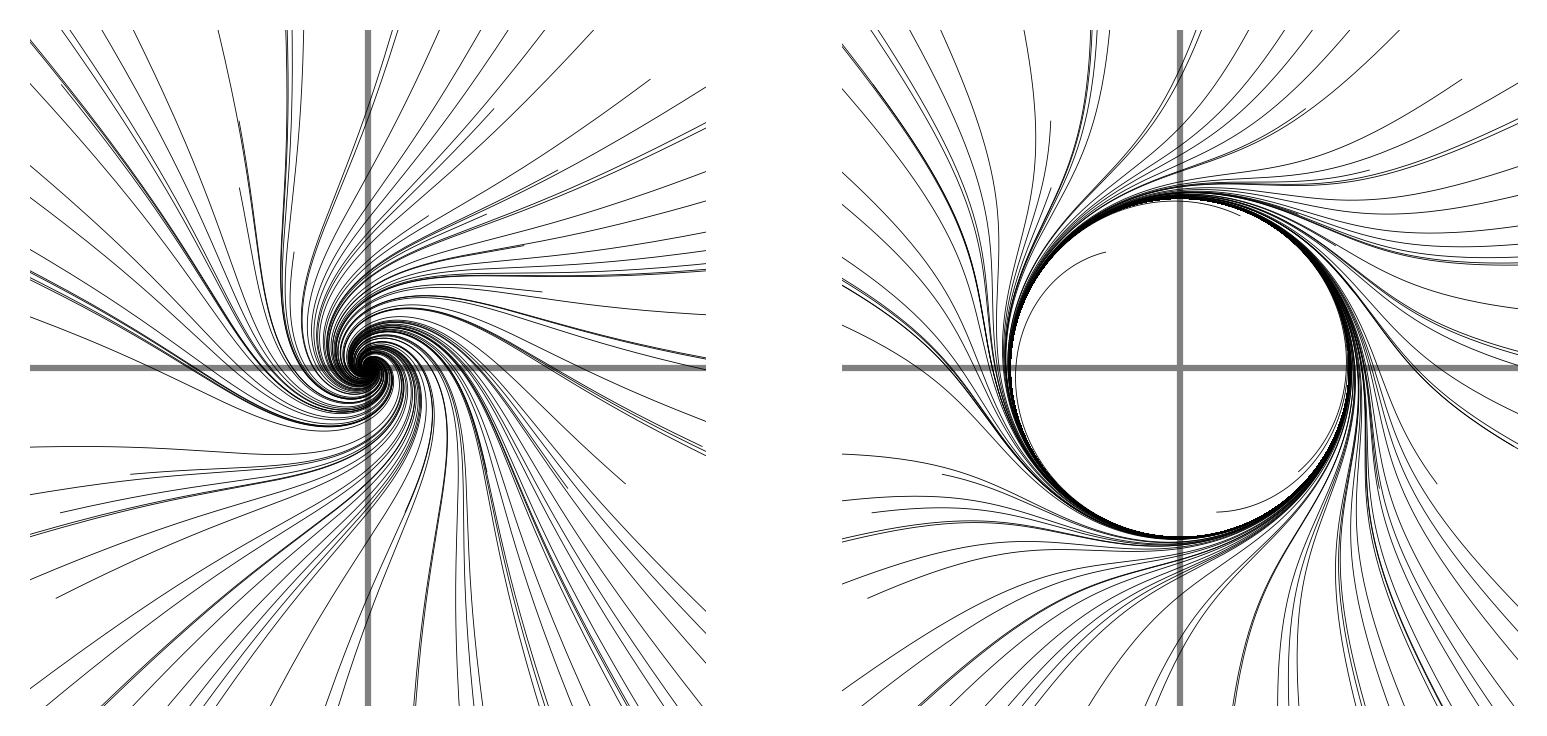

In [45]:
fig, axs = plt.subplots(1,2, dpi=300)
for i in range(2):
    for itr in range(ITR):
        axs[i].plot(x[i,:,itr], y[i,:,itr], 'k', linewidth=0.2)
        axs[i].set_aspect('equal')
        axs[i].set_xlim([-2, 2])
        axs[i].set_ylim([-2, 2])
        axs[i].set_xticks([])
        axs[i].set_yticks([])

for ax in axs:
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].plot([-2, 2], [0, 0], 'grey', zorder=-1)
axs[0].plot([0, 0], [-2, 2], 'grey', zorder=-1)
axs[1].plot([-2, 2], [0, 0], 'grey', zorder=-1)
axs[1].plot([0, 0], [-2, 2], 'grey', zorder=-1)
plt.show()

##### V0

In [4]:
np.random.seed(0)
cs = 0.0
T = 2500
osc = {}
params = {
    'alpha' : 0
}
alpha = [-0.05, 1]
ic = np.array([-2.5189366, 2.5189366]) # 10 * (np.random.rand(2,) - 0.5)
for i in range(len(alpha)):
    params['alpha'] = alpha[i]
    O = oscillator(ic.copy(), params.copy(), cs, T, otype='AH')
    osc[i] = O
        
for i in range(T-1):
    for k, v in osc.items():
        v.update()

x = np.zeros((len(alpha),T))
y = np.zeros((len(alpha),T))
z = np.zeros((len(alpha),T))
for k, v in osc.items():
    x[k,:] = v.traj[0,:]
    y[k,:] = v.traj[1,:]

In [8]:
ic

array([-11.5189366,  11.5189366])

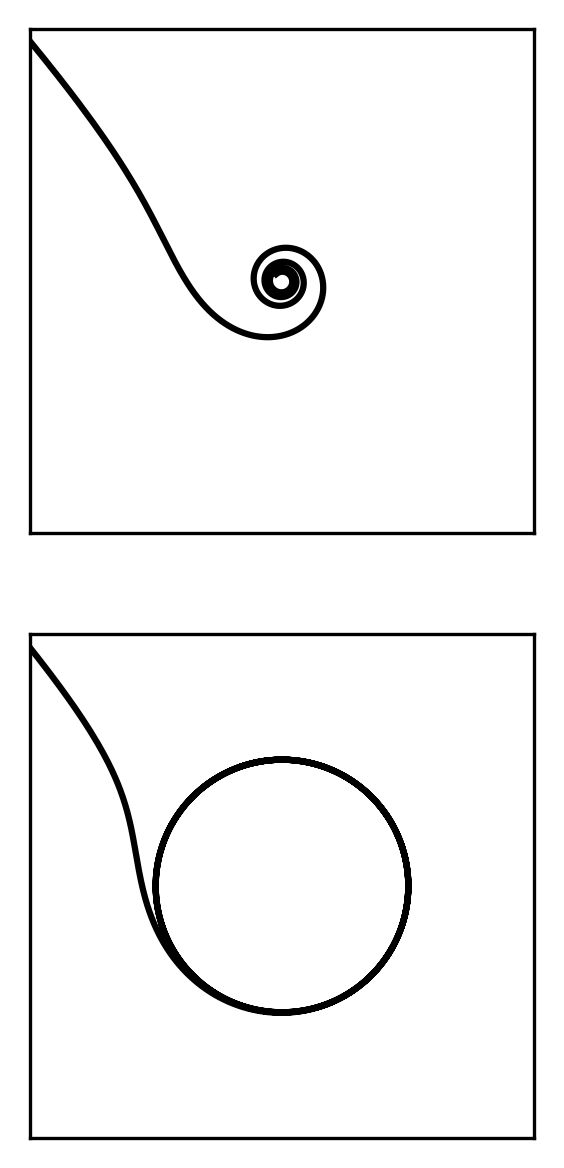

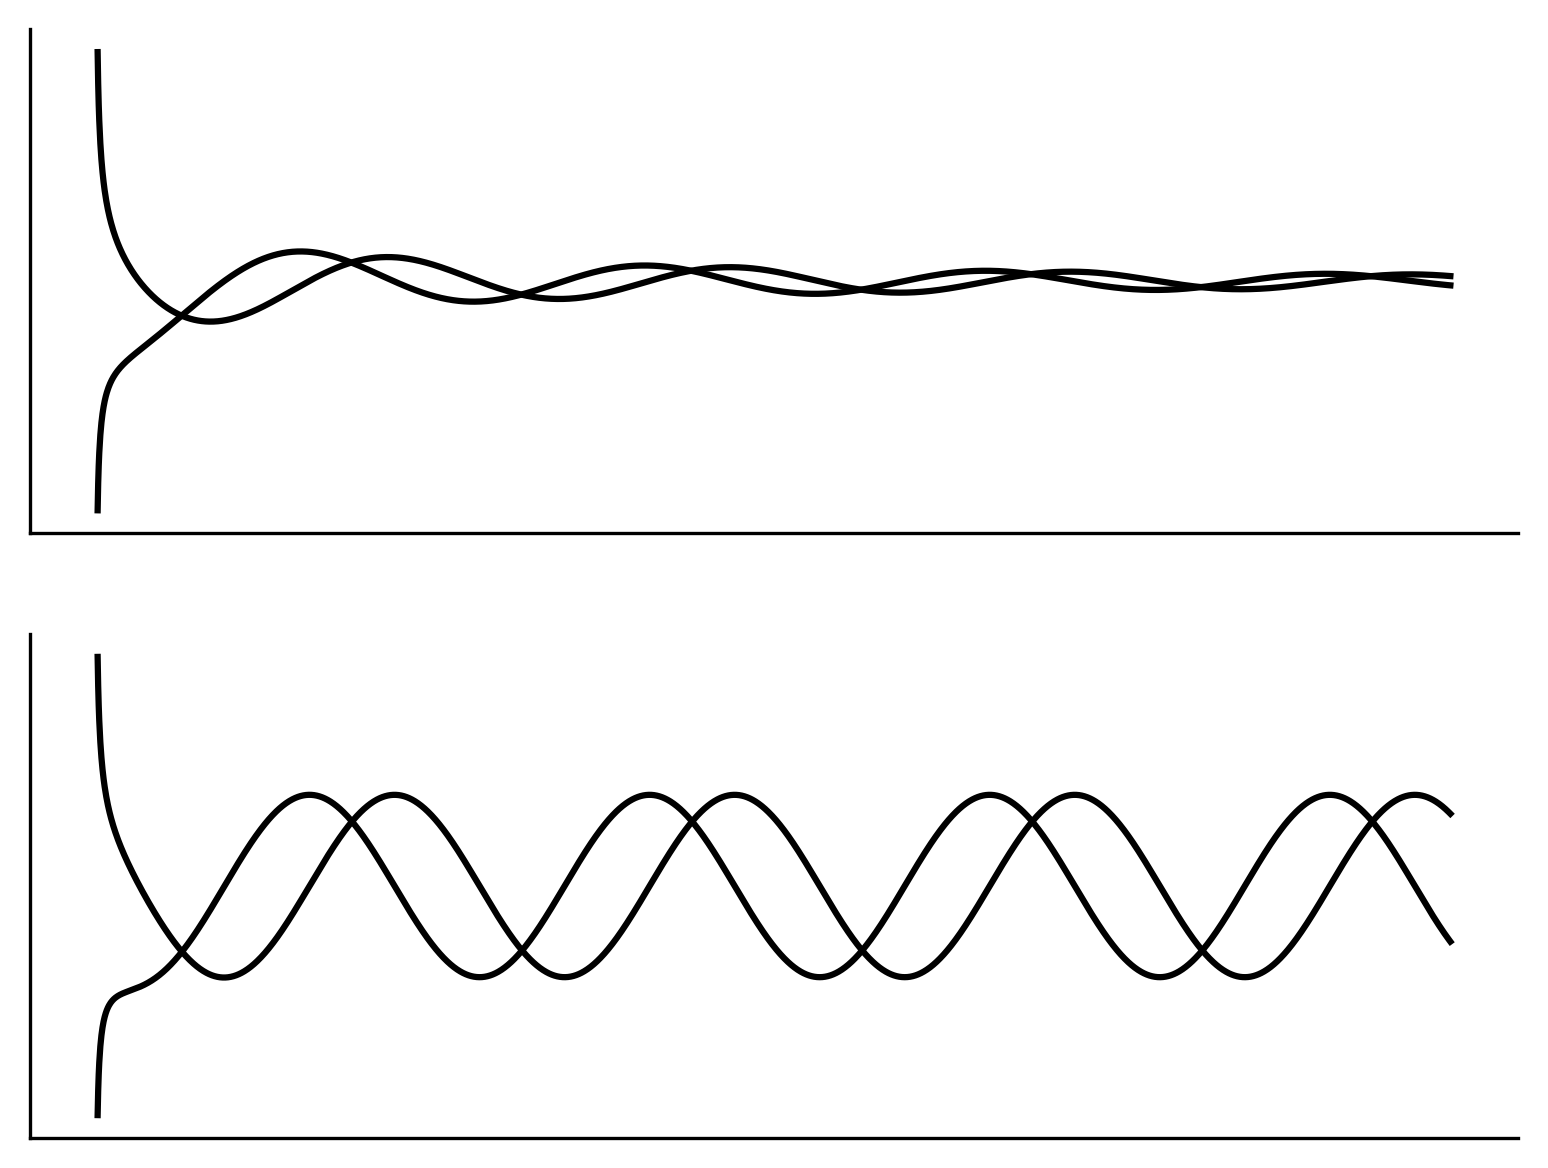

In [5]:
fig, axs = plt.subplots(2,1, dpi=300)
for i in range(2):
    axs[i].plot(x[i,:], y[i,:], 'k')
    axs[i].set_aspect('equal')
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-2, 2])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

fig, axs = plt.subplots(2,1, dpi=300)
for i in range(2):
    axs[i].plot(x[i,:], 'k')
    axs[i].plot(y[i,:], 'k')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
sns.despine()

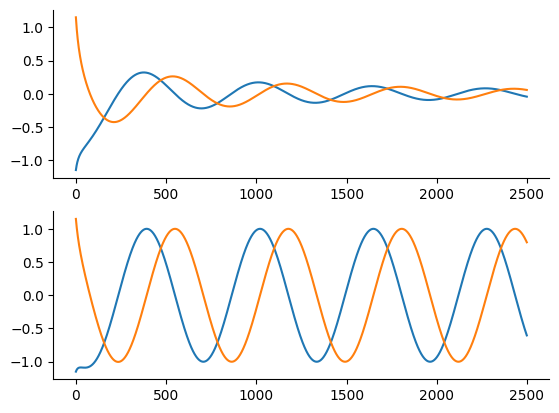

In [50]:
fig, axs = plt.subplots(2,1)
for i in range(2):
    axs[i].plot(x[i,:])
    axs[i].plot(y[i,:])
sns.despine()

#### EMGR Experiment

In [15]:
np.random.seed(0)
n = 500
cs = 0.0
T = 1000
osc = {}
params = {
    'alpha' : 0
}
alpha = np.arange(-15, 5, 0.1) # [-0.1, 0, 1]
for i in range(len(alpha)):
    x = 1 * (np.random.rand(2,) - 0.5)
    params['alpha'] = alpha[i]
    O = oscillator(x, params.copy(), cs, T, otype='AH')
    osc[i] = O
        
for i in range(T-1):
    for k, v in osc.items():
        v.update()

x = np.zeros((len(alpha),T))
y = np.zeros((len(alpha),T))
z = np.zeros((len(alpha),T))
for k, v in osc.items():
    x[k,:] = v.traj[0,:]
    y[k,:] = v.traj[1,:]

In [16]:
# alpha = np.arange(-40, 40, 0.1) # [-0.1, 0, 1]
# alpha = np.arange(-50, 50, 0.1) # [-0.1, 0, 1]
len(alpha)

200

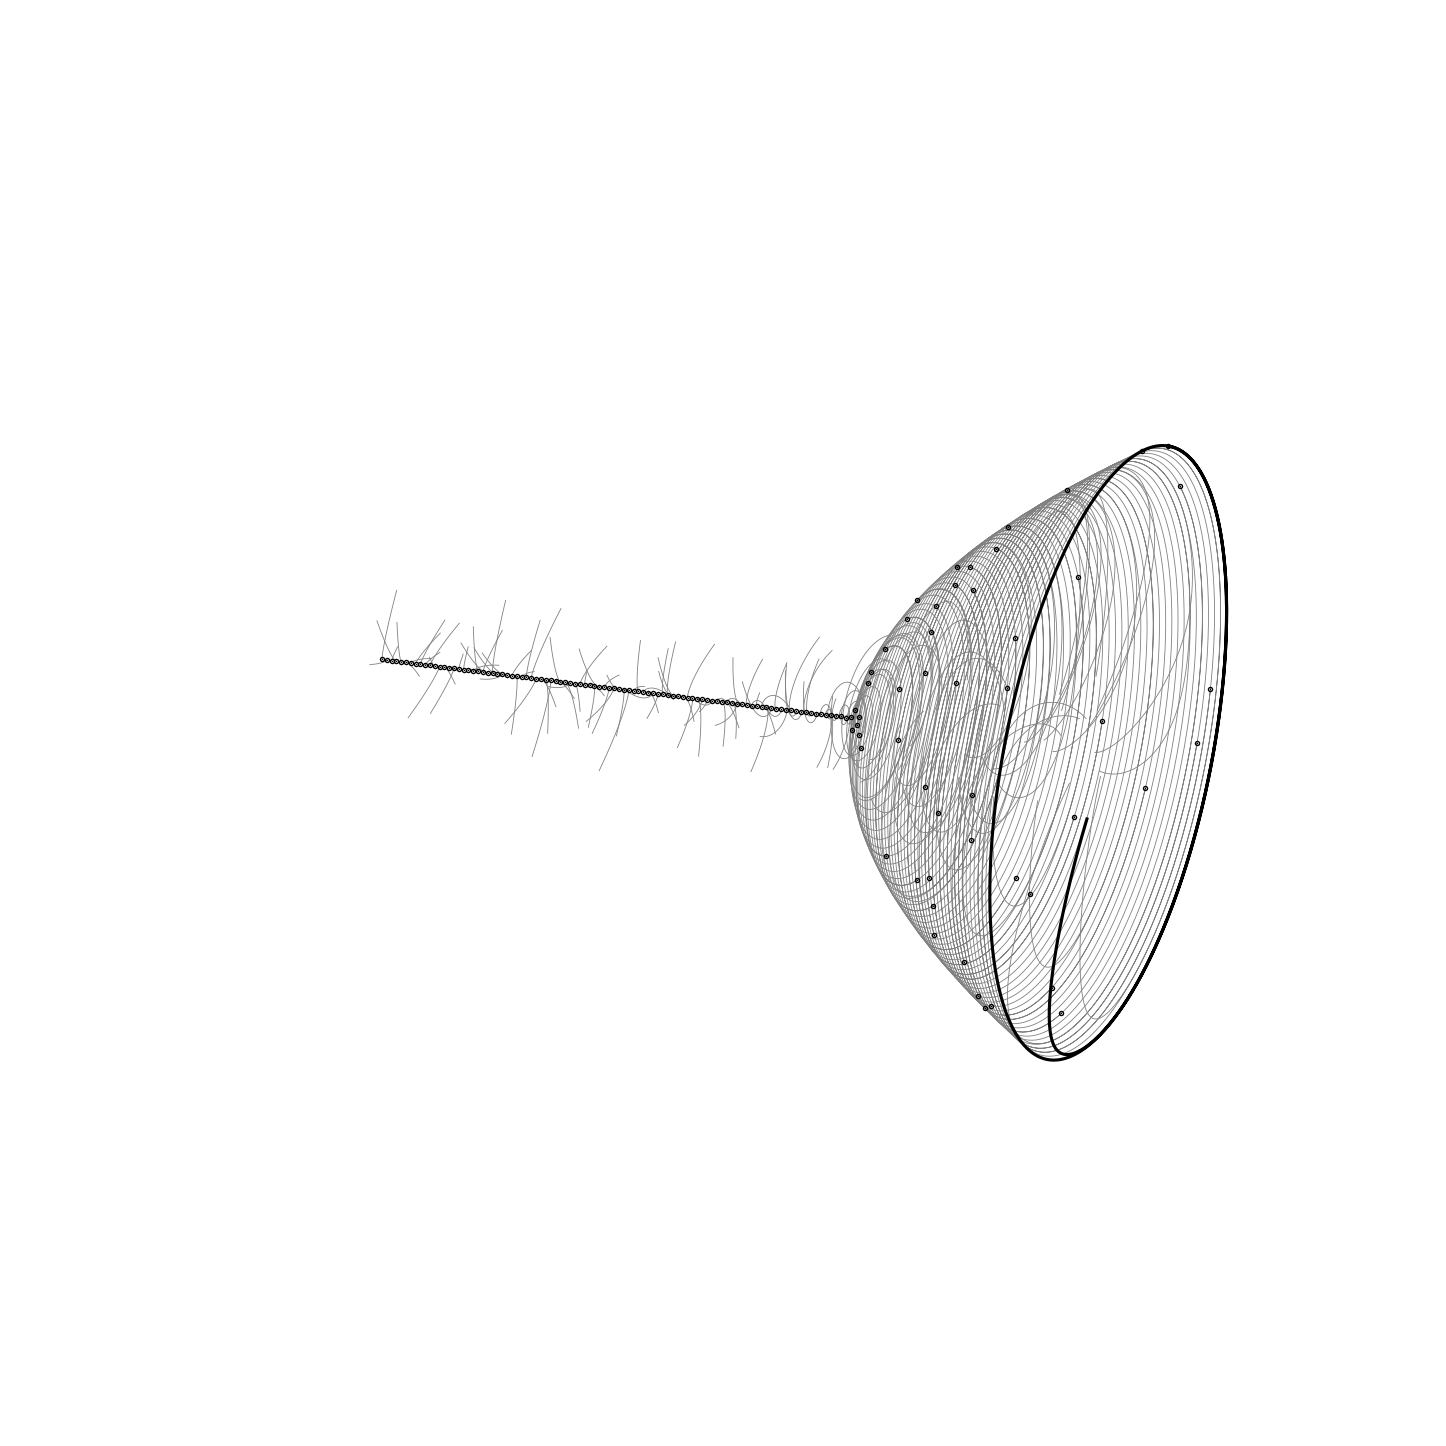

In [17]:
fig = plt.figure(dpi=300, figsize=(12,6))
ax = fig.add_subplot(111, projection='3d') #, shading='off')

# ax.plot([min(alpha), max(alpha)], [-1.2,-1.2], [-1.2,-1.2], color='k',    linewidth=1)
# ax.plot([min(alpha), min(alpha)], [-1.2,-1.2], [-1.2, 1.7], color='k', linewidth=1)
# ax.plot([min(alpha), min(alpha)], [-1.2, 2.5], [-1.2,-1.2], color='k',    linewidth=1)
for i in range(len(alpha)):
    if alpha[i] < -10: continue
    mu_vec = alpha[i] * np.ones_like(x[i,:])
    ax.scatter(mu_vec[0], x[i,-1], y[i,-1], color='k', s=0.1)
for i in range(len(alpha)):
    if alpha[i] < -10: continue

    mu_vec = alpha[i] * np.ones_like(x[i,:])
    ax.plot(mu_vec, x[i,:], y[i,:], color=(0.5,0.5,0.5), linewidth=0.2)
    if i == len(alpha) - 1:
        ax.plot(mu_vec, x[i,:], y[i,:], color='k', linewidth=0.75)
ax.set_xlabel('Bifurcation Parameter')

ax.axis('off')
ax.view_init(elev=20, azim=-70)
# fig.savefig('hopf-v2.png', transparent=True)
plt.show()

In [21]:
CTR = 0
def f(x,u,p,t):
    global CTR
    CTR += 1
    return andronov_hopf_oscillator(x, params)

def g0(x,u,p,t):
    C = np.array([[1.0,0.0]])
    y0 = C.dot(x)
#    print(f"{C.shape=}")
#    print(f"{x.shape=}")
#    print(f"{y0.shape=}")
#    print(f"{y0=}")
    return y0

def g1(x,u,p,t):
    C = np.array([[0.0,1.0]])
    return C.dot(x)

def g2(x,u,p,t):
    C = np.array([[0.1,0.0],
                  [0.0,1.0]])
    return C.dot(x)

np.random.seed(0)
n = 10
cs = 0.0
T = 1000
t = (0.01,1.0)
osc = {}
params = {
    'alpha' : 0
}
pr = np.zeros(100,)
alpha = np.arange(-50, 50, 1/n) # [-0.1, 0, 1]
print(f"{len(alpha)=}")
WO0, WO1, WO2 = {}, {}, {}
for i in range(len(alpha)):
    if i % 25 == 0:
        print(f"{i} / {n}")
    params['alpha'] = alpha[i]

    # TODO: get a steady state
    params['alpha'] = alpha[i]
    O = oscillator(np.zeros((2,)), params.copy(), cs, T, otype='AH')
    osc = {0: O}    
    for _ in range(T-1):
        for k, v in osc.items():
            v.update()

    x0 = v.traj[:,-1]
    X = 1 * (np.random.rand(2,) - 0.5)
    s = (1,2,1)
    WO0[alpha[i]] = emgr(f,g=g0,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
    X = 2 * (np.random.rand(2,) - 0.5)
    s = (1,2,1)
    WO1[alpha[i]] = emgr(f,g=g0,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
    X = 3 * (np.random.rand(2,) - 0.5)
    s = (1,2,1)
    WO2[alpha[i]] = emgr(f,g=g0,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)

#    WO1[alpha[i]] = emgr(f,g=g1,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
#    s = (1,2,2)
#    WO2[alpha[i]] = emgr(f,g=g2,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)

print(f"{CTR=}")

len(alpha)=1000
0 / 10
25 / 10
50 / 10
75 / 10
100 / 10
125 / 10
150 / 10
175 / 10
200 / 10
225 / 10
250 / 10
275 / 10
300 / 10
325 / 10
350 / 10
375 / 10
400 / 10
425 / 10
450 / 10
475 / 10
500 / 10
525 / 10
550 / 10
575 / 10
600 / 10
625 / 10
650 / 10
675 / 10
700 / 10
725 / 10
750 / 10
775 / 10
800 / 10
825 / 10
850 / 10
875 / 10
900 / 10
925 / 10
950 / 10
975 / 10
CTR=3600000


In [22]:
res = {
    'type': [],
    'trace': [],
    'alpha': []
}
for i in range(len(alpha)):
    tr0 = np.matrix.trace(WO0[alpha[i]])
    res['type'].append(0)
    res['trace'].append(tr0)
    res['alpha'].append(alpha[i])
    tr0 = np.matrix.trace(WO1[alpha[i]])
    res['type'].append(1)
    res['trace'].append(tr0)
    res['alpha'].append(alpha[i])
    tr0 = np.matrix.trace(WO2[alpha[i]])
    res['type'].append(2)
    res['trace'].append(tr0)
    res['alpha'].append(alpha[i])

df = pd.DataFrame(res)

Handles: [<matplotlib.lines.Line2D object at 0x1510b9bfe010>, <matplotlib.lines.Line2D object at 0x1511648e2290>, <matplotlib.lines.Line2D object at 0x1511640828d0>]
Labels: ['0', '1', '2']


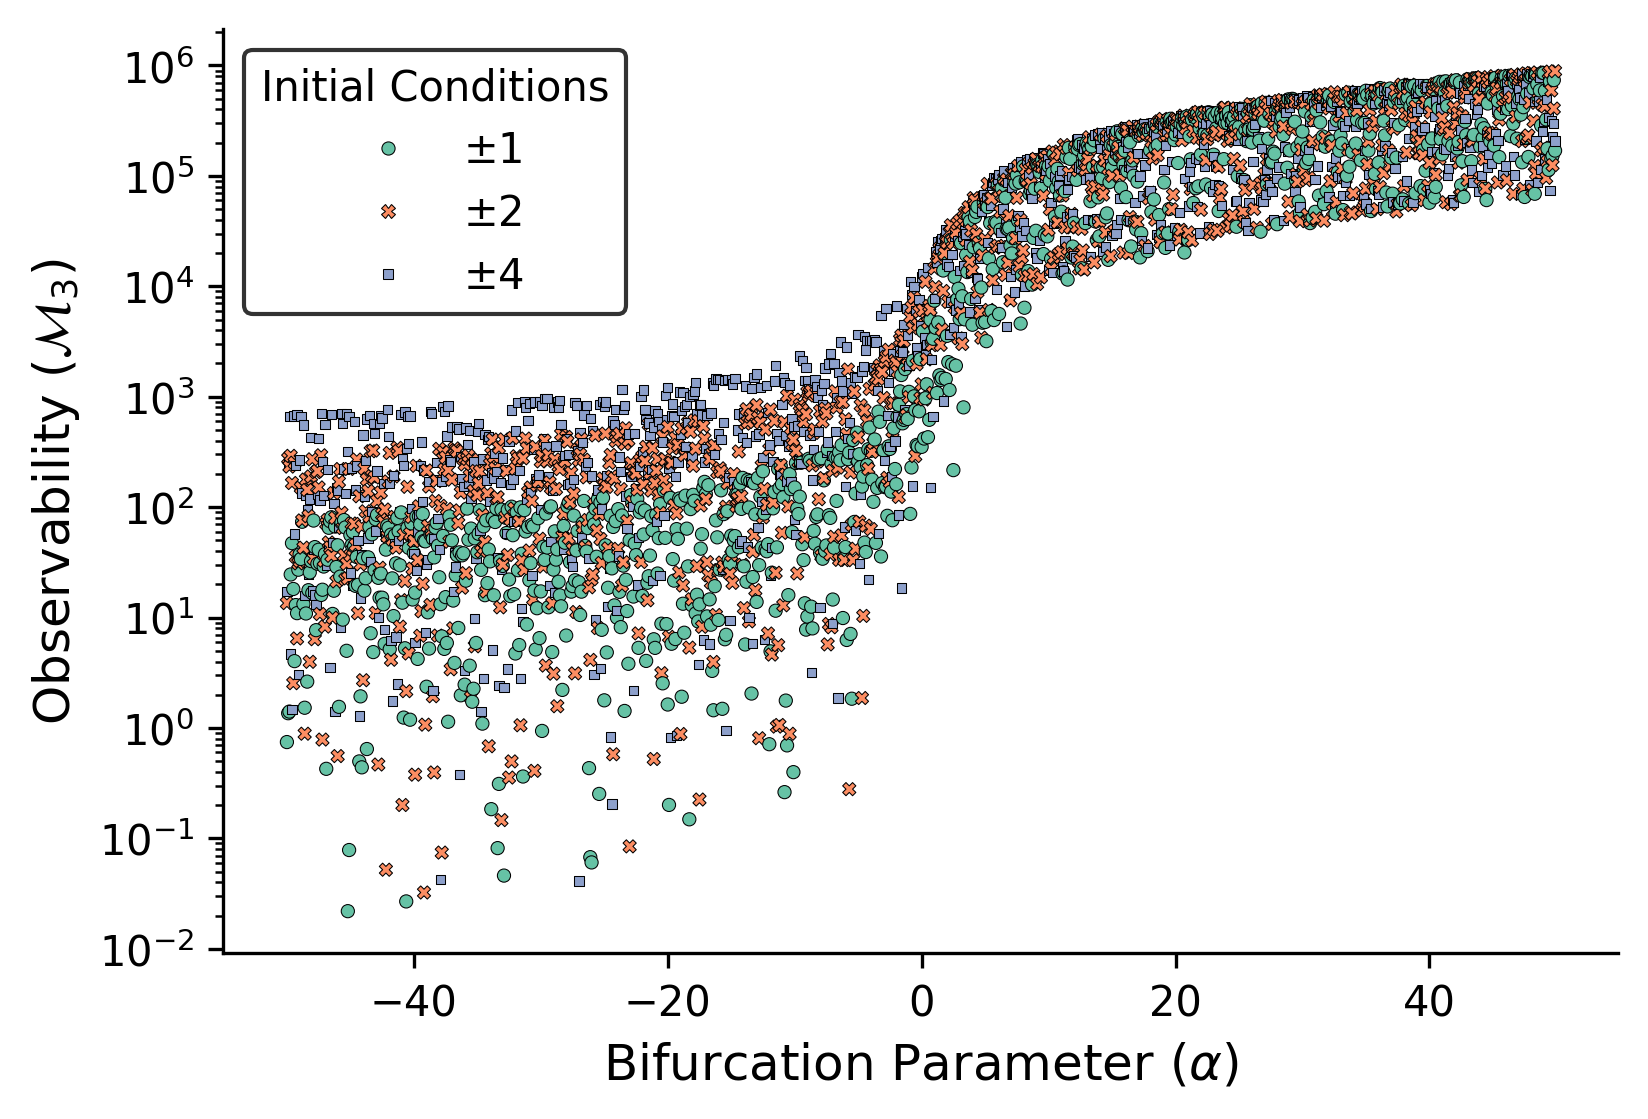

In [24]:
plt.figure(figsize=(6,4), dpi=300)

sns.scatterplot(
    data = df,
    x = 'alpha',
    y = 'trace',
    hue='type',
    s=10,
    ec='k',
    style='type',
    palette='Set2'
)

# Retrieve the default legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Print them to see the default values
print("Handles:", handles)
print("Labels:", labels)

labels = ['$\pm 1$', '$\pm 2$', '$\pm 4$']

# Customize the legend
plt.legend(
    handles=handles,  # Use the default handles
    labels=labels,
    title="Initial Conditions",
    title_fontsize='10',
    edgecolor='k'
)

plt.yscale('log')
# Axis labels with improved font sizes
plt.xlabel('Bifurcation Parameter ($\\alpha$)', fontsize=12)
plt.ylabel('Observability ($\mathcal{M}_3$)', fontsize=12)
sns.despine()
# plt.savefig('emgr-AH.png', transparent=True)
plt.show()


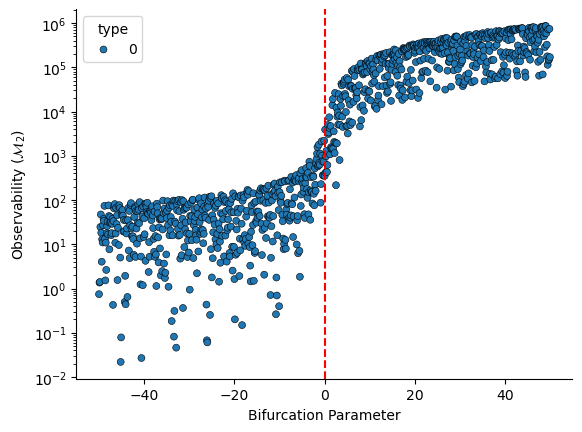

In [20]:
res = {
    'type': [],
    'trace': [],
    'alpha': []
}
for i in range(len(alpha)):
    tr0 = np.matrix.trace(WO0[alpha[i]])

    res['type'].append(0)
    res['trace'].append(tr0)
    res['alpha'].append(alpha[i])

df = pd.DataFrame(res)

plt.axvline(x=0, linestyle='--', color='r')

sns.scatterplot(
    data = df,
    x = 'alpha',
    y = 'trace',
    hue='type',
    s=25,
    ec='k',
    style='type'
)
plt.yscale('log')
plt.ylabel('Observability ($\mathcal{M}_2$)')
plt.xlabel('Bifurcation Parameter')
sns.despine()
plt.show()

In [24]:
df.to_csv(os.path.join('data', 'emgr-AH-oscillator-v2.csv'))

### Van Der Pol

In [26]:
CTR = 0
def f(x,u,p,t):
    global CTR
    CTR += 1
    return van_der_pol_oscillator(x, params)

def g0(x,u,p,t):
    C = np.array([[1.0,0.0]])
    y0 = C.dot(x)
    return y0

def g1(x,u,p,t):
    C = np.array([[0.0,1.0]])
    return C.dot(x)

def g2(x,u,p,t):
    C = np.array([[0.1,0.0],
                  [0.0,1.0]])
    return C.dot(x)

np.random.seed(0)
n = 10
cs = 0.0
T = 1000
osc = {}
params = {
    'alpha' : 0
}

np.random.seed(0)
n = 500
cs = 0.0
T = 1000
osc = {}
params = {}
mu = np.arange(-50, 50, 50/n)
pr = np.zeros(100,)
print(f"{len(mu)=}")
WO0, WO1, WO2 = {}, {}, {}
for i in range(len(mu)):
    if i % 25 == 0:
        print(f"{i} / {len(mu)}")
    params['mu'] = mu[i]

    # TODO: get a steady state
    O = oscillator(np.zeros((2,)), params.copy(), cs, T, otype='VDP')
    osc = {0: O}    
    for _ in range(T-1):
        for k, v in osc.items():
            v.update()

    x0 = v.traj[:,-1]
    X = x0 # [x0 for i in range(len(pr))]
    X = 1 * (np.random.rand(2,) - 0.5)
    s = (1,2,1)
    WO0[mu[i]] = emgr(f,g=g0,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
#    WO1[alpha[i]] = emgr(f,g=g1,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
#    s = (1,2,2)
#    WO2[alpha[i]] = emgr(f,g=g2,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)

print(f"{CTR=}")

len(mu)=1000
0 / 1000
25 / 1000
50 / 1000
75 / 1000
100 / 1000
125 / 1000
150 / 1000
175 / 1000
200 / 1000
225 / 1000
250 / 1000
275 / 1000
300 / 1000
325 / 1000
350 / 1000
375 / 1000
400 / 1000
425 / 1000
450 / 1000
475 / 1000
500 / 1000
525 / 1000
550 / 1000
575 / 1000
600 / 1000
625 / 1000
650 / 1000
675 / 1000
700 / 1000
725 / 1000
750 / 1000
775 / 1000
800 / 1000
825 / 1000
850 / 1000
875 / 1000
900 / 1000
925 / 1000
950 / 1000
975 / 1000
CTR=1200000


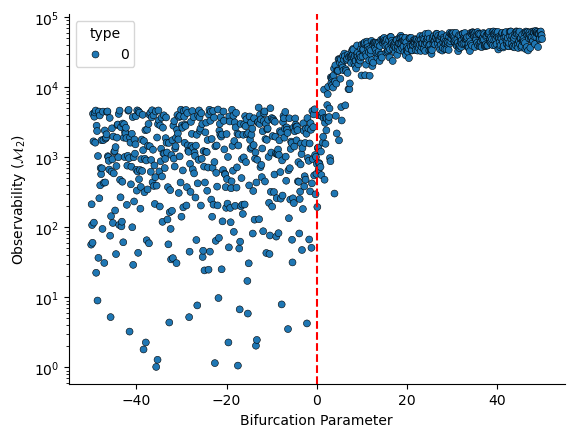

In [27]:
res = {
    'type': [],
    'trace': [],
    'alpha': []
}
for i in WO0.keys():
    tr0 = np.matrix.trace(WO0[i])
#    tr1 = np.matrix.trace(WO1[alpha[i]])
#    tr2 = np.matrix.trace(WO2[alpha[i]])

    res['type'].append(0)
    res['trace'].append(tr0)
    res['alpha'].append(i)

df = pd.DataFrame(res)

plt.axvline(x=0, linestyle='--', color='r')

sns.scatterplot(
    data = df,
    x = 'alpha',
    y = 'trace',
    hue='type',
    s=25,
    ec='k',
    style='type'
)
plt.yscale('log')
plt.ylabel('Observability ($\mathcal{M}_2$)')
plt.xlabel('Bifurcation Parameter')
sns.despine()
plt.show()

In [31]:
df.to_csv(os.path.join('data', 'emgr-VDP-oscillator-v2.csv'))

### Goodwin Oscillator

In [88]:
CTR = 0
def f(x,u,p,t):
    global CTR
    global params
    CTR += 1
    return goodwin_oscillator_3var(x, params)

def g0(x,u,p,t):
    C = np.array([[1.0,0.0, 0.0]])
    y0 = C.dot(x)
    return y0

np.random.seed(0)
n = 10
cs = 0.0
T = 1000
osc = {}
params = {
    'alpha' : 0
}

np.random.seed(0)
n = 500
cs = 0.0
T = 1000
osc = {}
global params
params = {
    'n'     : 20,
    'alpha' : 0
}
mu = np.arange(-0, 50, 50/n)
pr = np.zeros(100,)
print(f"{len(mu)=}")
WO0, WO1, WO2 = {}, {}, {}
for i in range(len(mu)):
    if i % 25 == 0:
        print(f"{i} / {len(mu)}")
    params['alpha'] = mu[i]

    # TODO: get a steady state
    O = oscillator(np.zeros((3,)), params.copy(), cs, T, otype='GW3')
    osc = {0: O}    
    for _ in range(T-1):
        for k, v in osc.items():
            v.update()

    x0 = v.traj[:,-1]
    X = x0 # [x0 for i in range(len(pr))]
    s = (1,3,1)
    WO0[mu[i]] = emgr(f,g=g0,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
#    WO1[alpha[i]] = emgr(f,g=g1,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)
#    s = (1,2,2)
#    WO2[alpha[i]] = emgr(f,g=g2,s=s,t=t,w="o", pr=pr, xs=X, xm=0.01)

print(f"{CTR=}")

len(mu)=30
0 / 30
25 / 30
CTR=54000


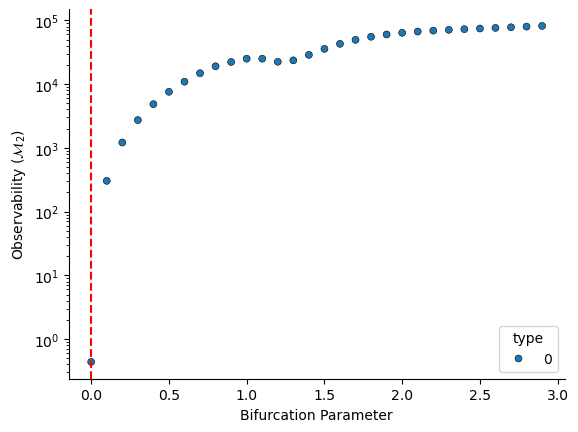

In [89]:
res = {
    'type': [],
    'trace': [],
    'alpha': []
}
for i in WO0.keys():
    tr0 = np.matrix.trace(WO0[i])

    res['type'].append(0)
    res['trace'].append(tr0)
    res['alpha'].append(i)

df = pd.DataFrame(res)

plt.axvline(x=0, linestyle='--', color='r')

sns.scatterplot(
    data = df,
    x = 'alpha',
    y = 'trace',
    hue='type',
    s=25,
    ec='k',
    style='type'
)
plt.yscale('log')
plt.ylabel('Observability ($\mathcal{M}_2$)')
plt.xlabel('Bifurcation Parameter')
sns.despine()
plt.show()

In [83]:
df.to_csv(os.path.join('data', 'emgr-GW3-oscillator.csv'))

#### Test

In [99]:
np.random.seed(0)
n = 500
cs = 0.0
T = 500
osc = {}
params = {
    'n'     : 20,
    'alpha' : 0
}
mu = np.arange(-20, 20, 1.5/n) # [-0.1, 0, 1]
for i in range(n):
    x = 1 * (np.random.rand(3,)) # - 0.5)
    params['alpha'] = mu[i]
    O = oscillator(x, params.copy(), cs, T, otype='GW3')
    osc[i] = O
        
for i in range(T-1):
    for k, v in osc.items():
        v.update()

x = np.zeros((n,T))
y = np.zeros((n,T))
z = np.zeros((n,T))
for k, v in osc.items():
    x[k,:] = v.traj[0,:]
    y[k,:] = v.traj[1,:]
    z[k,:] = v.traj[2,:]

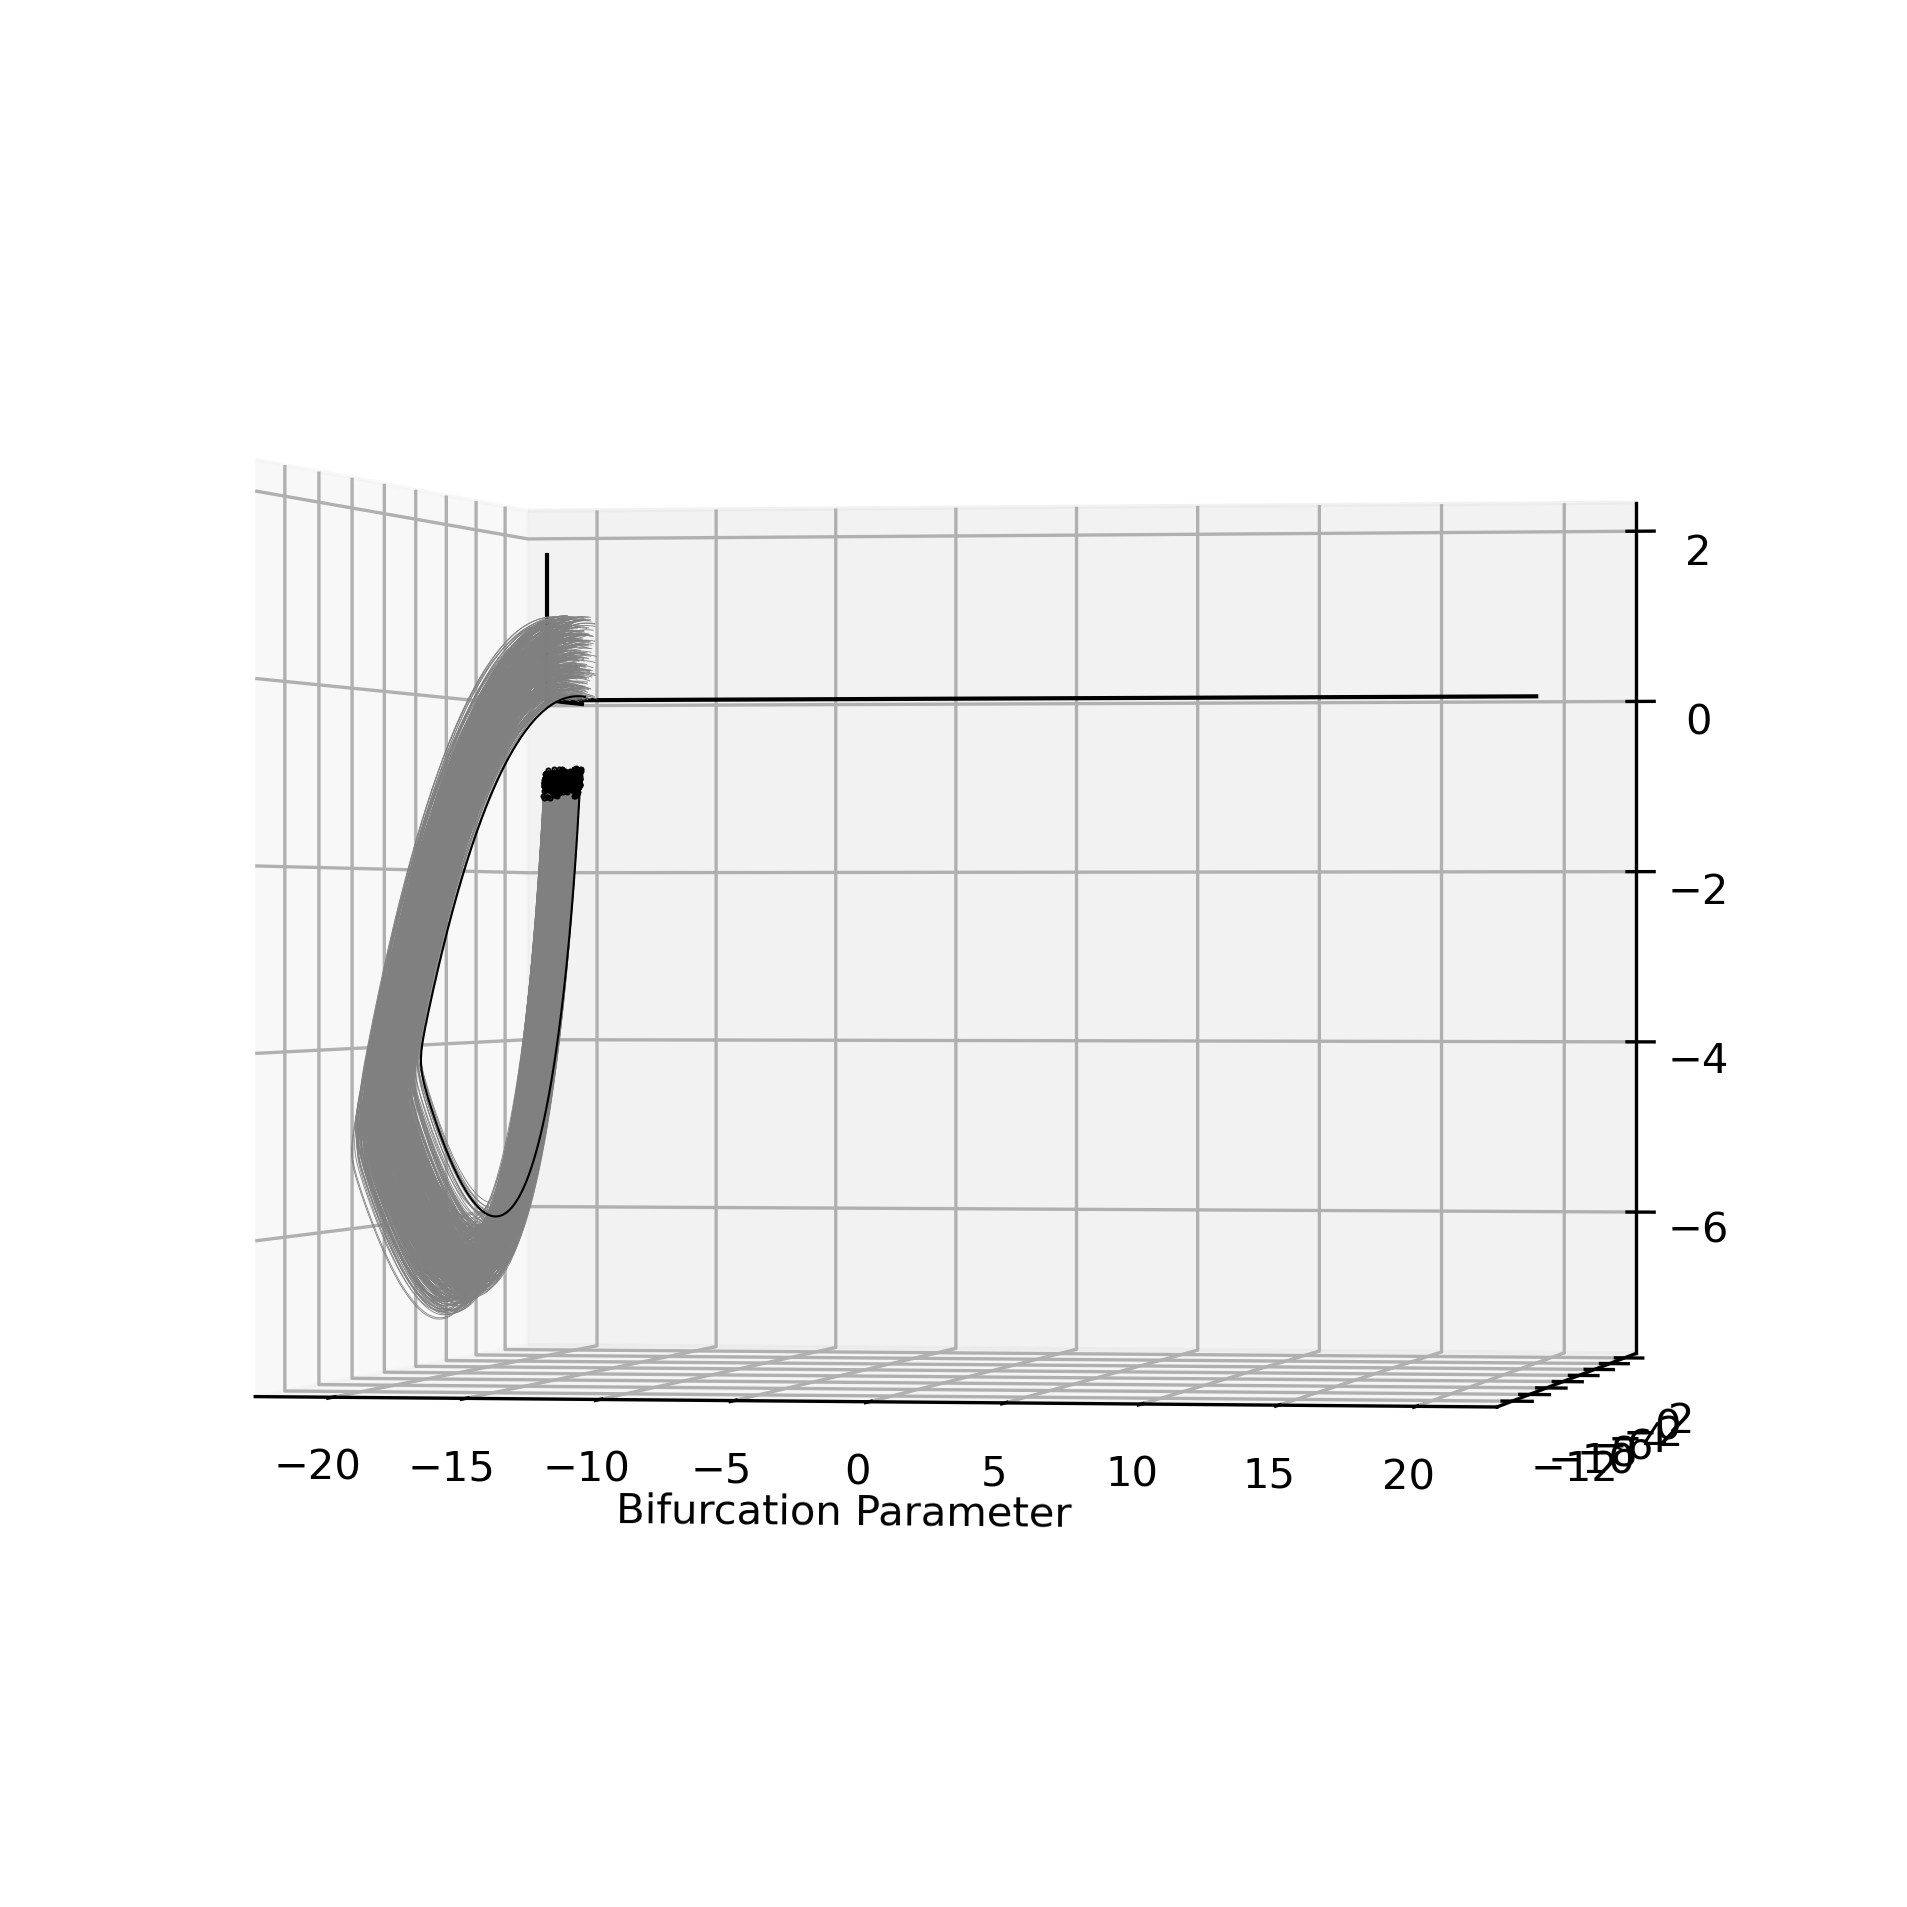

In [100]:
fig = plt.figure(dpi=300, figsize=(10,8))
ax = fig.add_subplot(111, projection='3d') #, shading='off')

ax.plot([min(mu), max(mu)], [0,0], [0,0], color='k',    linewidth=1)
ax.plot([min(mu), min(mu)], [0,0], [0, 1.7], color='k', linewidth=1)
ax.plot([min(mu), min(mu)], [0,   2.5], [0,0], color='k',    linewidth=1)
for i in range(n):
    mu_vec = mu[i] * np.ones_like(x[i,:])
    ax.scatter(mu_vec[0], x[i,-1], y[i,-1], color='k', s=0.2)
for i in range(n):
    mu_vec = mu[i] * np.ones_like(x[i,:])
    ax.plot(mu_vec, x[i,:], y[i,:], color=(0.5,0.5,0.5), linewidth=0.2)
    if i == n-1:
        ax.plot(mu_vec, x[i,:], y[i,:], color='k', linewidth=0.5)
ax.set_xlabel('Bifurcation Parameter')

#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])

# ax.axis('off')
ax.view_init(elev=0, azim=-80)
plt.show()

## All Oscillators Example

In [32]:
df0 = pd.read_csv(os.path.join('data', 'emgr-AH-oscillator-v2.csv'))
df1 = pd.read_csv(os.path.join('data', 'emgr-VDP-oscillator-v2.csv'))
# df2 = pd.read_csv(os.path.join('data', 'emgr-GW3-oscillator.csv'))

df0['Type'] = 'Andronov Hopf'
df1['Type'] = 'Van Der Pol'
# df2['Type'] = 'GW3'

df = pd.concat((df0, df1), axis=0)
df

Unnamed: 0  type         trace  alpha           Type
0             0     0      0.745789  -50.0  Andronov Hopf
1             1     0      3.396752  -49.9  Andronov Hopf
2             2     0      1.933920  -49.8  Andronov Hopf
3             3     0      1.364945  -49.7  Andronov Hopf
4             4     0     69.525921  -49.6  Andronov Hopf
..          ...   ...           ...    ...            ...
995         995     0  61678.718662   49.5    Van Der Pol
996         996     0  62746.301342   49.6    Van Der Pol
997         997     0  55415.595099   49.7    Van Der Pol
998         998     0  55297.043008   49.8    Van Der Pol
999         999     0  49033.157600   49.9    Van Der Pol

[2000 rows x 5 columns]

Unnamed: 0  type         trace  alpha Type
0             0     0      0.016069  -50.0   AH
1             1     0      0.016087  -49.9   AH
2             2     0      0.016105  -49.8   AH
3             3     0      0.016123  -49.7   AH
4             4     0      0.016141  -49.6   AH
..          ...   ...           ...    ...  ...
995         995     0  46431.645044   49.5  VDP
996         996     0  46454.850770   49.6  VDP
997         997     0  46477.973417   49.7  VDP
998         998     0  46501.013928   49.8  VDP
999         999     0  46523.973078   49.9  VDP

[2000 rows x 5 columns]

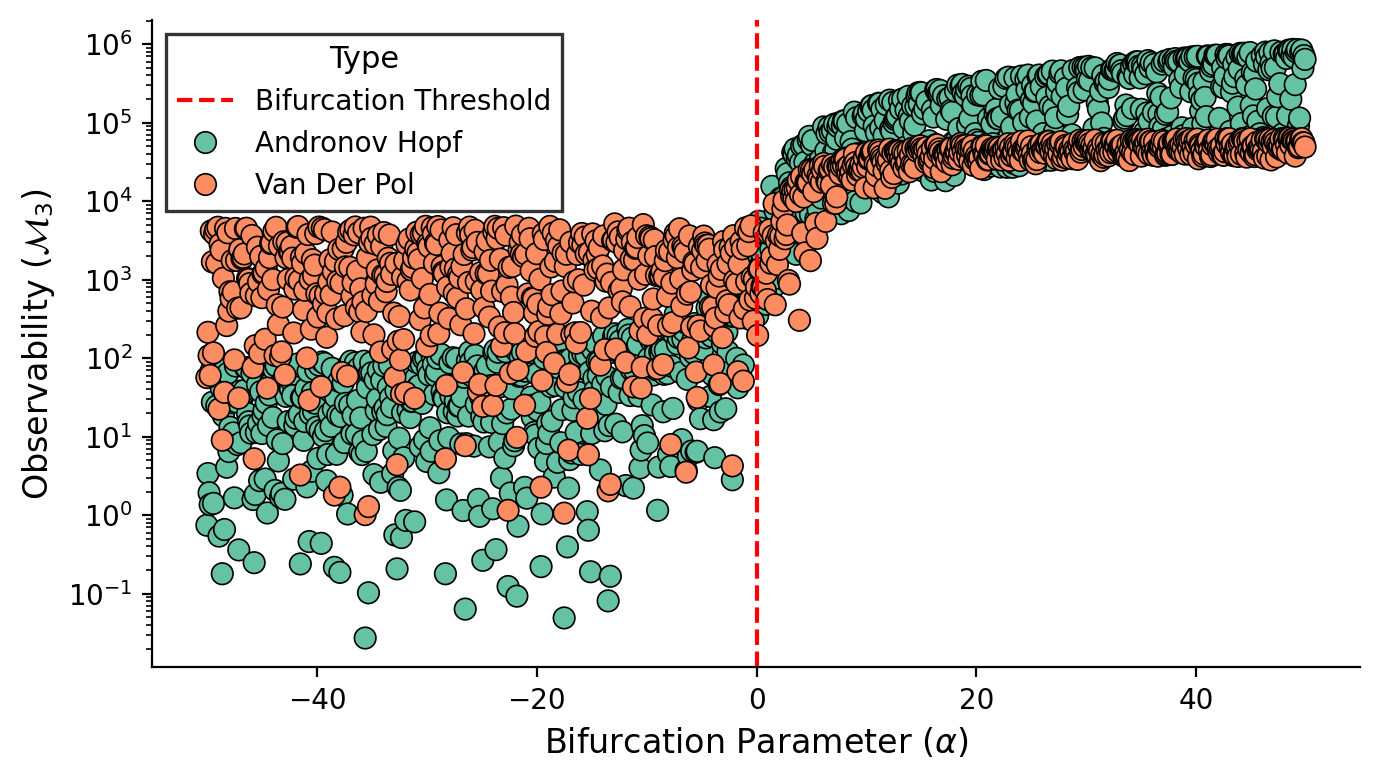

In [39]:
plt.figure(figsize=(7, 4), dpi=200)

# Draw the vertical line for reference
plt.axvline(x=0, linestyle='--', color='red', label="Bifurcation Threshold")

# Enhanced scatter plot
sns.scatterplot(
    data=df,
    x='alpha',
    y='trace',
    hue='Type',
    palette='Set2',          # Softer color palette
    s=60,                    # Larger marker size for better visibility
    edgecolor='black',       # Black edge color to highlight points
    linewidth=0.6,           # Thin edge line
    marker='o'               # Circle markers
)

# Set logarithmic scale for y-axis
plt.yscale('log')

# Axis labels with improved font sizes
plt.xlabel('Bifurcation Parameter ($\\alpha$)', fontsize=12)
plt.ylabel('Observability ($\mathcal{M}_3$)', fontsize=12)

# Customize legend
plt.legend(title='Oscillator', loc='upper left', fontsize=10, title_fontsize=11, frameon=True)
# Customize legend with black box and sharp corners
legend = plt.legend(
    title='Type', loc='upper left', fontsize=10, title_fontsize=11, 
    frameon=True, fancybox=False, edgecolor='black'
)
legend.get_frame().set_linewidth(1.2)    # Thicker border for the box
legend.get_frame().set_facecolor('white')  # Background color of the legend box


# Despine and set tighter layout
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


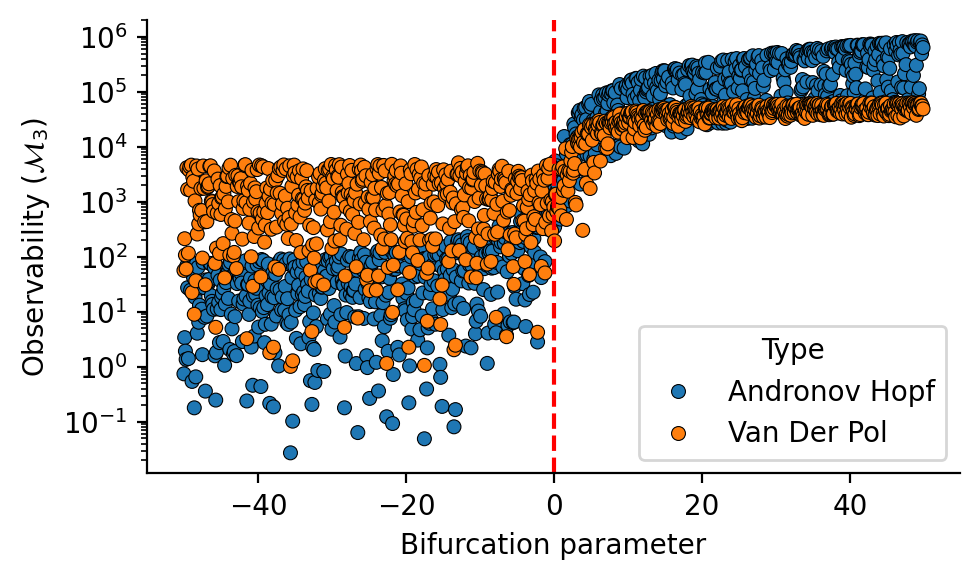

In [36]:
plt.figure(figsize=(5,3), dpi=200)
plt.axvline(x=0, linestyle='--', color='r')
sns.scatterplot(
    data = df,
    x = 'alpha',
    y = 'trace',
    hue='Type',
    s=25,
    ec='k',
)
plt.yscale('log')

plt.xlabel('Bifurcation parameter')
plt.ylabel('Observability ($\mathcal{M}_3$)')
sns.despine()
plt.tight_layout()
plt.show()